# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

## Problem 1 (8 points)

There are two csv-files in the [/data](./data) folder:

- `origins.csv`
- `destinations.csv`

The files contain coordinates of the origin and destination points in certain area of the world as latitude and longitude coordinates (decimal degrees). 

**1: Your task is to find out where the points are located based on the coordinates found in the files** (which city/country?) Use your GIS skills to find out the solution in two different ways.

In [76]:
import os
os.getcwd()

'C:\\Users\\Rimpula\\Desktop\\GIS-Python\\exercise-6-main\\exercise-6-main'

A. detect the location using **visualization techniques**; plot the points on top of a background map and see where they are located! 

In [77]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import folium
import osmnx as ox
import matplotlib.pyplot as plt
fp = 'data/origins.csv'
fp1 = 'data/destinations.csv'

origins = pd.read_csv(fp, sep=',')
dest = pd.read_csv(fp1, sep=',')
print(origins.head())
print(dest.head())

         x        y
0  24.6159  59.4052
1  24.6407  59.4074
2  24.6686  59.4018
3  24.6980  59.4477
4  24.7680  59.4303
         x        y
0  24.8441  59.4395
1  24.6150  59.3433
2  24.8656  59.4405
3  24.6983  59.4013
4  24.7630  59.4407


In [3]:
m = folium.Map(location=[59.4052,24.6159], control_scale=True)
m
# Tallinn, Estonia

B. Detect the location using **geocoding techniques**; reverse geocode at least one of the locations (see [hints from geopy documentation](https://geopy.readthedocs.io/en/stable/index.html?highlight=reverse#module-geopy.geocoders)). As output, you should print out information about the location (can be a full address, or just the name of the city):

In [4]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="reverse_geocoder")
location = geolocator.reverse("59.4052,24.6159")
print(location)

Astangu Rimi super, 4, Kotermaa, Astangu, Haabersti linnaosa, Tallinn, Harju maakond, 13524, Eesti


**2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located.**

- Specify a Polygon that covers the **extent where all the points are located*. 
- Store the extent as a Shapely Polygon stored in a variable called `graph_extent`.
- Add a little bit of buffer around the extent for downloading the graph, so that you cover all routes between the points.
- See hints from this [week's hints page](https://autogis-site.readthedocs.io/en/latest/lessons/L6/exercise-6.html#hints) on how to define the extent.

In [78]:
orig_dest = origins.append(dest, ignore_index=True)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_28452\1826445762.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  orig_dest = origins.append(dest, ignore_index=True)


In [79]:
x_min = orig_dest['x'].min()
x_max = orig_dest['x'].max()
y_min = orig_dest['y'].min()
y_max = orig_dest['y'].max()
# buffered x & y
print(x_min, y_min,y_max, x_max)

24.5598 59.3224 59.4912 24.8921


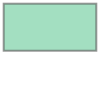

In [80]:
from shapely.geometry import Point, Polygon, MultiPoint, LineString
polygon = Polygon([(x_min, y_min), (x_min,y_max), (x_max, y_max), (x_max,y_min)])
polygon
convex = MultiPoint([(x_min, y_min), (x_min,y_max), (x_max, y_max), (x_max,y_min)]).convex_hull
convex

In [81]:
buf_bbox = polygon.buffer(0.05)
graph_extent = buf_bbox

# Tallinn, Estonia

In [10]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(graph_extent)

POLYGON ((24.5598 59.272400000000005, 24.554899142983523 59.272640763666395, 24.550045483899193 59.27336073597984, 24.545285766137276 59.27455298321339, 24.540665828381744 59.276206023374435, 24.5362301631587 59.278303936782585, 24.53202148834902 59.280826519384874, 24.528080335791817 59.28374947733187, 24.52444466094067 59.28704466094067, 24.52114947733186 59.29068033579182, 24.51822651938487 59.29462148834902, 24.515703936782582 59.298830163158705, 24.513606023374436 59.30326582838175, 24.511952983213387 59.307885766137275, 24.510760735979837 59.312645483899196, 24.51004076366639 59.31749914298352, 24.5098 59.3224, 24.5098 59.4912, 24.51004076366639 59.49610085701648, 24.510760735979837 59.500954516100805, 24.511952983213387 59.505714233862726, 24.513606023374436 59.510334171618254, 24.515703936782582 59.514769836841296, 24.51822651938487 59.51897851165098, 24.52114947733186 59.52291966420818, 24.52444466094067 59.52655533905933, 24.528080335791817 59.529850522668134, 24.532021488349

In [11]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(type(graph_extent))

<class 'shapely.geometry.polygon.Polygon'>


- Use the polygon to fetch the drivable network data with `.graph_from_polygon()` function 
- Remember to specify correct `network_type`
- see [osmnx docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon) for more details
- store the street network a variable called `graph`

In [82]:
graph = ox.graph_from_polygon(graph_extent, network_type="drive")

In [13]:
# NON-EDITABLE TEST CELL
# The graph should be a networkx MultiDiGraph
print(type(graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [14]:
# NON-EDITABLE TEST CELL
# Check the graph size. The example solution graph size is 28756 (don't panic if yours is not exactly the same, you can still proceed!)
print(graph.size())

27395


In [83]:
# origin and dest points to geometry column and gdf
origins['geometry'] = None
dest['geometry'] = None
points = []
for x,y in zip(origins['x'],origins['y']):
    point = Point([x,y])
    points.append(point)
origins['geometry']=points
points = []
for x,y in zip(dest['x'],dest['y']):
    point = Point([x,y])
    points.append(point)
dest['geometry']=points

origins_gdf=gpd.GeoDataFrame(origins, geometry='geometry')
dest_gdf=gpd.GeoDataFrame(dest, geometry='geometry')
nodes, edges = ox.graph_to_gdfs(graph)

C:\ProgramData\Miniconda3\envs\geo\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


**3: Reproject the data into UTM projection, and plot:**
  - the street network (with `gray` color and line width of `0.5` and alpha set to `0.7`)
  - the origin points (with `red` color)
  - destination points (with `blue` color)
  
In the end you should have a map that looks something like following:

![](img/route_network_with_OD_points.png)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

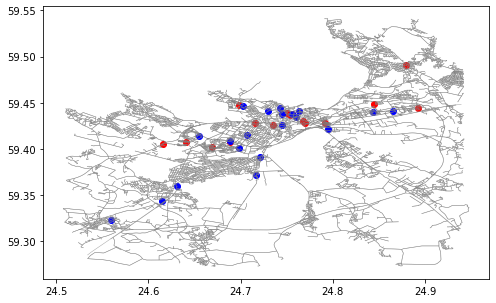

In [56]:

fig, ax = plt.subplots(figsize=(8,8))
edges.plot(ax=ax, linewidth = 0.5, color='grey', alpha=0.7)
origins_gdf.plot(ax=ax, color='red')

dest_gdf.plot(ax=ax, color='blue')
plt.tight_layout

### Done!

That's it! Now you can continue with problem 2. 

## Problem 2 (12 points)

In this problem we practice conducting shortest path routing.

### Steps

**1: Calculate the shortest paths between all origin points (16) and destination points (20) using the `length` of the road segments as the impedance measure (in total 320 routes).** 

- To be able to find the shortest paths, you should find the nearest nodes from the graph for both origin and destination points. 
- Notice: if the closest node is the same for both origin and destination point, you should skip the shortest path calculation. - After the routing, you should add the shortest path routes as LineString geometries into a GeoDataFrame called `routes`. 
- You should use the projected graph as the network for the analyses
- remember to use informative variable names, and to comment your code!

In [84]:
# Store the shortest path routes as LineString geometries in a GeoDataFrame called routes:
routes = None

import networkx as nx

graph_proj = ox.project_graph(graph)

nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True,edges=True)
print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [87]:
CRS(edges_proj.crs).to_epsg()

32635

In [88]:
# Had some problems getting the crs correct but seems to work with this
origins_gdf = origins_gdf.set_crs(4326)
origins_gdf = origins_gdf.to_crs(CRS(nodes_proj.crs))
origins_gdf.head()

,x,y,geometry
0,24.6159,59.4052,POINT (364659.492 6587597.013)
1,24.6407,59.4074,POINT (366075.637 6587791.721)
2,24.6686,59.4018,POINT (367637.096 6587112.547)
3,24.6980,59.4477,POINT (369482.650 6592163.774)
4,24.7680,59.4303,POINT (373385.475 6590091.584)


In [89]:
# Destinations to correct crs
dest_gdf = dest_gdf.set_crs(4326)
dest_gdf = dest_gdf.to_crs(CRS(nodes_proj.crs))

In [90]:
# getting xy pairs (not needed with new nearest nodes)
orig_xy = (origins_gdf.y,origins_gdf.x)
dest_xy = (dest_gdf.y,dest_gdf.x)

<AxesSubplot:>

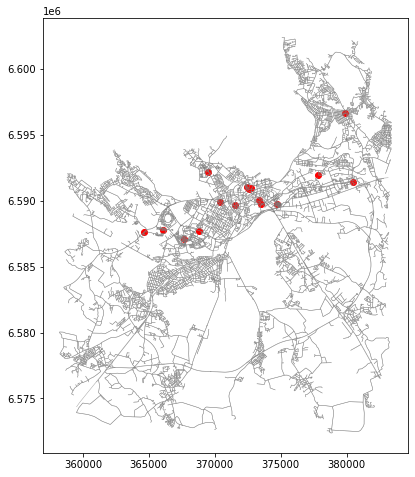

In [92]:
# Test plotting
fig, ax = plt.subplots(figsize=(8,8))
edges_proj.plot(ax=ax, linewidth = 0.5, color='grey', alpha=0.7)
origins_gdf.plot(ax=ax, color='red')

In [98]:
# The OSmnx has updated their functions so for the nearest_nodes I'm inputting the x and y separately from their gdfs.
orig_node_id = ox.distance.nearest_nodes(graph_proj, origins_gdf['geometry'].x, origins_gdf['geometry'].y)
target_node_id = ox.distance.nearest_nodes(graph_proj, dest_gdf['geometry'].x, dest_gdf['geometry'].y)

In [100]:
orig_node = nodes_proj.loc[orig_node_id]
target_node = nodes_proj.loc[target_node_id]

In [215]:
len(orig_node)

16

In [104]:
route = nx.shortest_path(G=graph_proj, source=orig_node_id[0], target=target_node_id[0], weight='length')
print(route)

[341986868, 256061995, 256061932, 5903321422, 5903321409, 5903321417, 5903321416, 1598966843, 5899330966, 5899330971, 256057388, 347545401, 314579876, 256057429, 5820982391, 256061761, 5654412821, 5676215748, 1684948002, 318876388, 696784279, 71055887, 313001398, 11274204, 2155894110, 313001427, 245395551, 245397980, 245405466, 245493270, 245396551, 245407826, 245396117, 636105665, 5868334883, 57660158, 57660159, 421713953, 75700995, 75703007, 246996872, 57659512, 59963240, 57662141, 57658072, 57661635, 57661636, 57655741, 420840495, 301662211, 10580351, 391282724, 628214843, 61914139, 5730948295, 278373176, 10579259, 61908693, 919096979, 312955801, 312955816, 10579215, 57665671, 57665673, 57665677, 57665679, 1045305804, 385811068, 1432105289, 312969618, 31225243, 10581142, 10581136, 5928600761, 311933492, 5525116900, 31923155, 5928195560, 31225231, 7100254198, 344394983, 5933312936, 10580951, 10580943, 87967149, 361086283, 10580942, 10580959, 361090974, 614488572, 11784754, 11784764, 

In [259]:
# Looping through the origin and target nodes. If they are different, calculating the shortest path. Adding each linestring
# geometry to list_route list
from shapely.geometry import LineString 
list_route = []
#osmid_list = []
for row in orig_node_id:
    for targets in target_node_id:
        if row !=  targets:
            route = nx.shortest_path(G=graph_proj, source=row, target=targets, weight='length')
            route_nodes = nodes_proj.loc[route]

            route_line = LineString(list(route_nodes.geometry.values))
            list_route.append(route_line)
            #osmid_list.append(route_nodes.index)

In [238]:
# creating a gdf with the defined list
routes = gpd.GeoDataFrame(list_route, geometry='geometry', crs=edges_proj.crs, columns=['geometry']) 
#routes.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))
routes['length_m'] = routes.length


In [268]:
#routes['osmids'] = str(osmid_list)
#routes


,geometry,osmids,length_m,route_dist
0,"LINESTRING (364723.450 6587654.149, 364688.064...","[Int64Index([ 341986868, 256061995, 25606193...",14754.554329,14754.554329
1,"LINESTRING (364723.450 6587654.149, 364688.064...","[Int64Index([ 341986868, 256061995, 25606193...",8804.204190,8804.204190
2,"LINESTRING (364723.450 6587654.149, 364688.064...","[Int64Index([ 341986868, 256061995, 25606193...",16061.603078,16061.603078
3,"LINESTRING (364723.450 6587654.149, 365376.539...","[Int64Index([ 341986868, 256061995, 25606193...",5243.387176,5243.387176
4,"LINESTRING (364723.450 6587654.149, 364688.064...","[Int64Index([ 341986868, 256061995, 25606193...",10238.582938,10238.582938
...,...,...,...,...
314,"LINESTRING (372468.156 6590999.766, 372596.898...","[Int64Index([ 341986868, 256061995, 25606193...",1881.524515,1881.524515
315,"LINESTRING (372468.156 6590999.766, 372443.035...","[Int64Index([ 341986868, 256061995, 25606193...",2105.373951,2105.373951
316,"LINESTRING (372468.156 6590999.766, 372596.898...","[Int64Index([ 341986868, 256061995, 25606193...",1395.592971,1395.592971
317,"LINESTRING (372468.156 6590999.766, 372443.035...","[Int64Index([ 341986868, 256061995, 25606193...",1311.624240,1311.624240


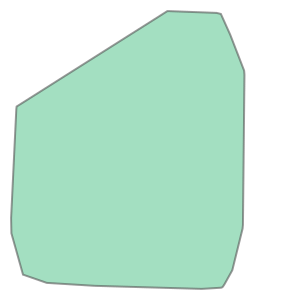

**2: Calculate the distance of the routes in meters into a new column called `route_dist`.**
 

In [262]:
routes['route_dist'] = routes['length_m']

In [263]:
# NON-EDITABLE TEST CELL
print("Shortest distance:", round(routes['route_dist'].min()), "meters")

Shortest distance: 279 meters


In [264]:
# NON-EDITABLE TEST CELL (longest distance in the example solution is 29177 meters)
print("Longest distance:", round(routes['route_dist'].max()), "meters")

Longest distance: 28721 meters


**3: Plot all the routes on top of the street network.** 

In the end you should have something like following:
 
 ![](img/routings.png)

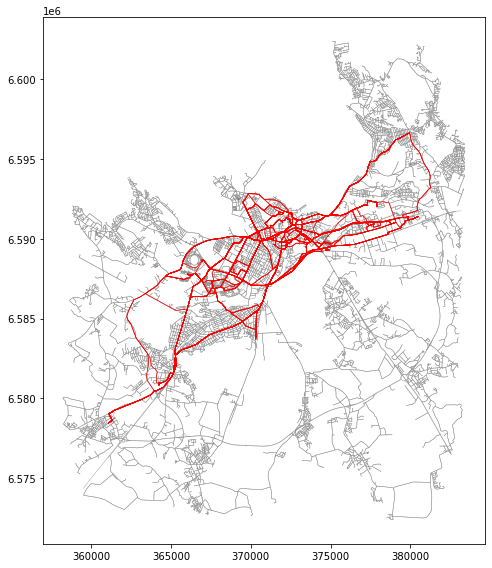

In [265]:
fig, ax = plt.subplots(figsize=(8,8))
edges_proj.plot(ax=ax, linewidth = 0.5, color='grey', alpha=0.7)
routes.plot(ax=ax, linewidth = 0.7, color='red')
plt.tight_layout()

**4: Calculate the total distance of all the routes (i.e. sum of all route distances)** Update the `total_distance` based on your calculations:

In [266]:
total_distance = 0

for row in routes['route_dist']:
    total_distance += row
total_distance

2459921.6819120203

In [267]:
# NON-EDITABLE TEST CELL (example solution: 2468 kilometers)
#Print your solution:
print("Total distance of all routes is: %.0f kilometers" % (total_distance / 1000))


Total distance of all routes is: 2460 kilometers


### Done!

That's it! Now you have finished all the practical exercises of the course (except final assignment), congratulations! :)